# Online Selection of HLS Representations

In [1]:
from lrcb.bandits.multirep_finite import FiniteMultiBandit
from lrcb.representations.finite_representations import make_random_rep, hls_rank, rank, derank_hls, make_hls_rank
from lrcb.representations.finite_representations import is_cmb, is_hls, spans, hls_lambda, derank_cmb, LinearRepresentation
from lrcb.algos.oful import oful
from lrcb.algos.lr_oful import select_oful
from lrcb.algos.maximin_oful import maximin_oful
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lrcb.visualization.notebook_utils as nu
from jupyterthemes import jtplot
#jtplot.style()
plt.rcParams['figure.figsize'] = [12, 9]

## Common settings

In [2]:
nc = 100
na = 5
dim = 20
noise = 0.1
seeds = range(5)

Generate original HLS representation

In [3]:
r0 = make_random_rep(nc, na, dim, normalize=True)
assert is_hls(r0)

OFUL settings

In [4]:
iterations = 10000
reg = 0.1
delta = 0.1
param_bound = 1. #Guaranteed by make_random_rep(..., normalize=True)

## CMB, destructive approach (different parameter) (t)

Re-use the same original HLS representation

Generate non-HLS **equivalent** representations with varying HLS rank **and different parameters**

In [5]:
reps = [derank_hls(r0, i, transform=True, normalize=True) for i in range(1, dim)] #Random transformation preserving equivalence
reps.append(r0)

for i, r in enumerate(reps[:-1]):
    assert r == reps[-1] #All representations are equivalent
    assert not np.allclose(r._param, reps[-1]._param) #But with different parameters!
    assert not is_hls(r) #Only the original one is HLS
    assert spans(r) #All representations still span R^d
    print('%d/%d %s %f %f' % (hls_rank(r), rank(r), '(CMB)' if is_cmb(r) else '', r.feat_bound(), r.feat_bound(reduce=np.min)))
print('%d/%d %s %f %f' % (hls_rank(reps[-1]), rank(reps[-1]), '(CMB)' if is_cmb(r) else '', reps[-1].opt_feat_bound(), reps[-1].opt_feat_bound(reduce=np.min)))

#Buldi multi-representation problem
problem = FiniteMultiBandit(nc, na, reps)

1/20 (CMB) 17.423838 0.015334
2/20 (CMB) 17.423838 0.015307
3/20 (CMB) 17.423838 0.015316
4/20 (CMB) 17.423838 0.015315
5/20 (CMB) 17.423838 0.015280
6/20 (CMB) 17.423838 0.015278
7/20 (CMB) 17.423838 0.015230
8/20 (CMB) 17.423838 0.015218
9/20 (CMB) 17.423838 0.015215
10/20 (CMB) 17.423838 0.015155
11/20 (CMB) 17.423838 0.015253
12/20 (CMB) 17.423838 0.015272
13/20 (CMB) 17.423838 0.015327
14/20 (CMB) 17.423838 0.015322
15/20 (CMB) 17.423838 0.015329
16/20 (CMB) 17.423838 0.015335
17/20 (CMB) 17.423838 0.015447
18/20 (CMB) 17.423838 0.015456
19/20 (CMB) 17.423838 0.015434
20/20 (CMB) 14.070491 8.130994


Regret of OFUL with different representations

In [6]:
for i in range(len(reps)):
    problem.select_rep(i)
    name = 'oful_rank%d(t)' % hls_rank(reps[i])
    for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname=name)

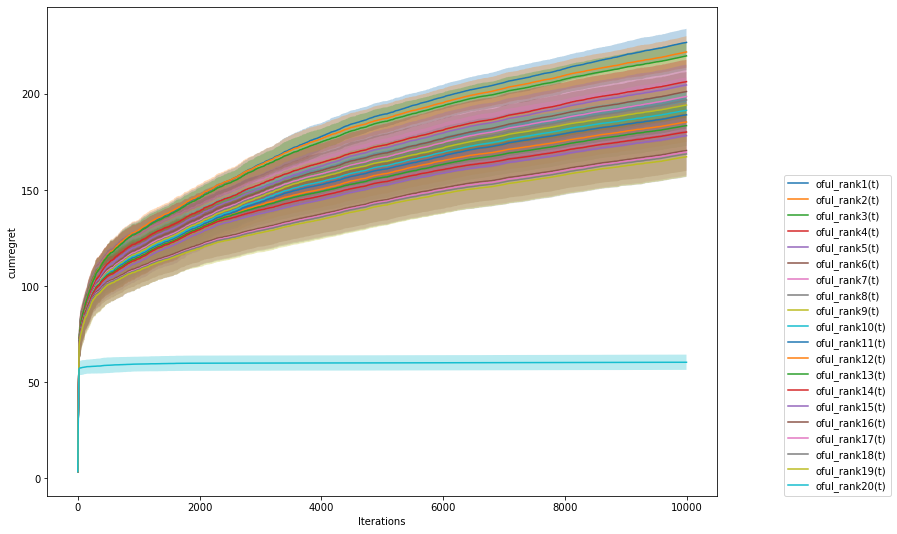

In [7]:
names = ['oful_rank%d(t)' % (i+1) for i in range(dim)]
nu.compare('../logs', names, 'cumregret', seeds)

(Final) cumulated regret is (almost) sorted by hls rank, with the HLS representation having a large advantage

In [8]:
ranking = nu.tournament('../logs', names, 'cumregret', seeds)
ranking

[('oful_rank20(t)', 60.2659196724336),
 ('oful_rank19(t)', 167.23759543815063),
 ('oful_rank18(t)', 168.70842541447968),
 ('oful_rank17(t)', 169.68046999002507),
 ('oful_rank16(t)', 170.48758771785975),
 ('oful_rank15(t)', 178.2355581887378),
 ('oful_rank14(t)', 180.12285136277728),
 ('oful_rank13(t)', 183.4446934728294),
 ('oful_rank12(t)', 185.34970891557535),
 ('oful_rank11(t)', 189.06943040950165),
 ('oful_rank10(t)', 191.38822914247186),
 ('oful_rank9(t)', 194.17387621271678),
 ('oful_rank8(t)', 196.80090404666322),
 ('oful_rank7(t)', 198.63346210176888),
 ('oful_rank6(t)', 201.19992347566546),
 ('oful_rank5(t)', 204.6199662257132),
 ('oful_rank4(t)', 206.34625919586307),
 ('oful_rank3(t)', 219.7433909496354),
 ('oful_rank2(t)', 221.78631025525448),
 ('oful_rank1(t)', 226.76061621090776)]

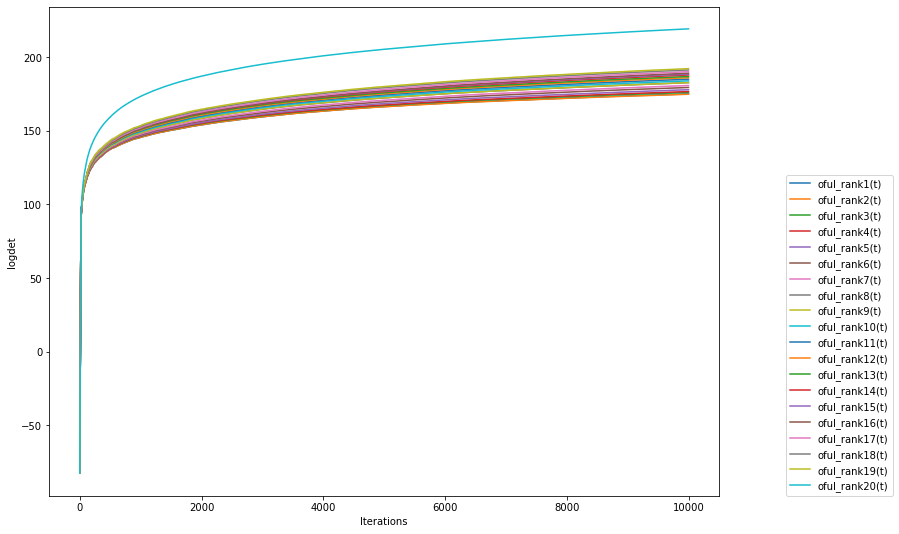

In [9]:
nu.compare('../logs', names, 'logdet', seeds)

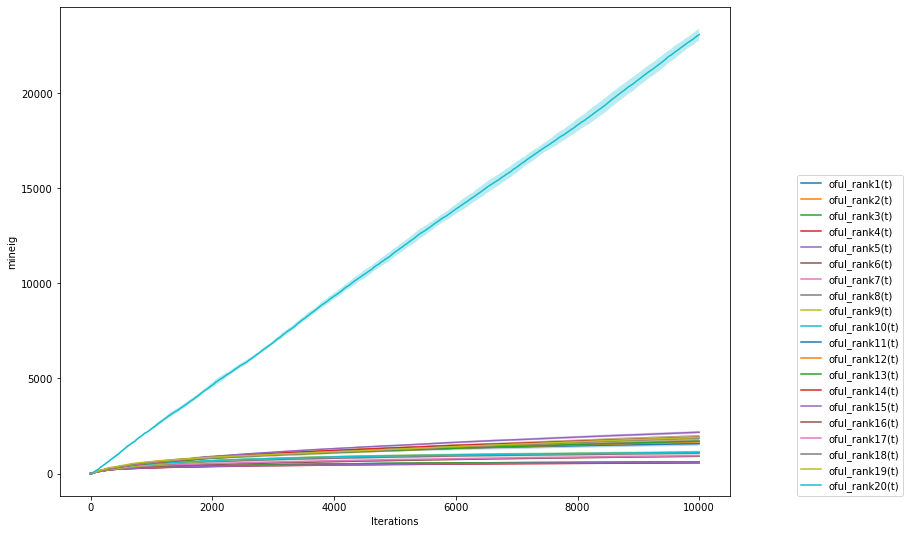

In [10]:
nu.compare('../logs', names, 'mineig', seeds)

Regret of model-selection algorithm compared to best model

In [11]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta/20, param_bound, 
                rule='maxlambdamin',
                seed=seed, verbose=False, logname='oful_select(t)')

In [12]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta/20, param_bound, 
                rule='minbonus',
                seed=seed, verbose=False, logname='oful_meta(t)')

In [13]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta/20, param_bound,
                seed=seed, verbose=False, logname='oful_maximin(t)')

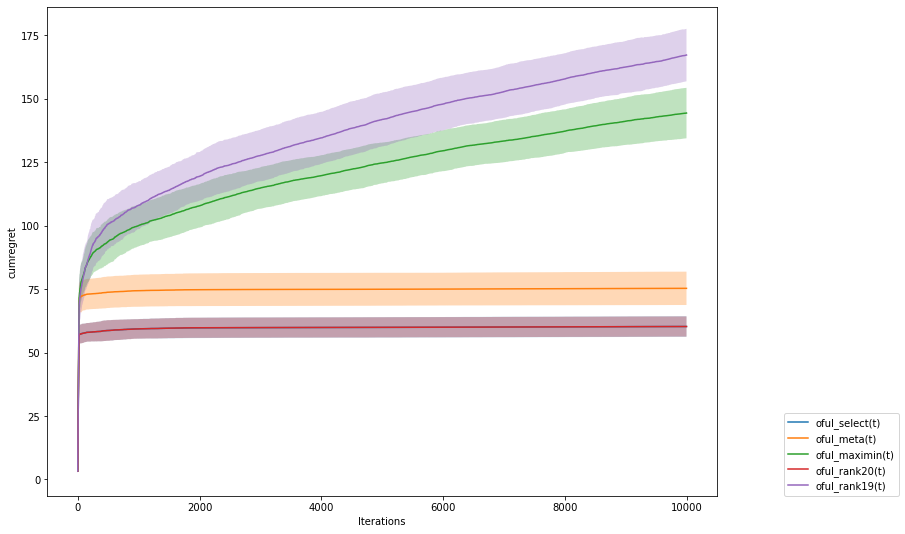

In [14]:
best = ranking[0][0]
nu.compare('../logs', ['oful_select(t)', 'oful_meta(t)', 'oful_maximin(t)', best, ranking[1][0]], 'cumregret', seeds)

Representations selected by model-selection algorithms

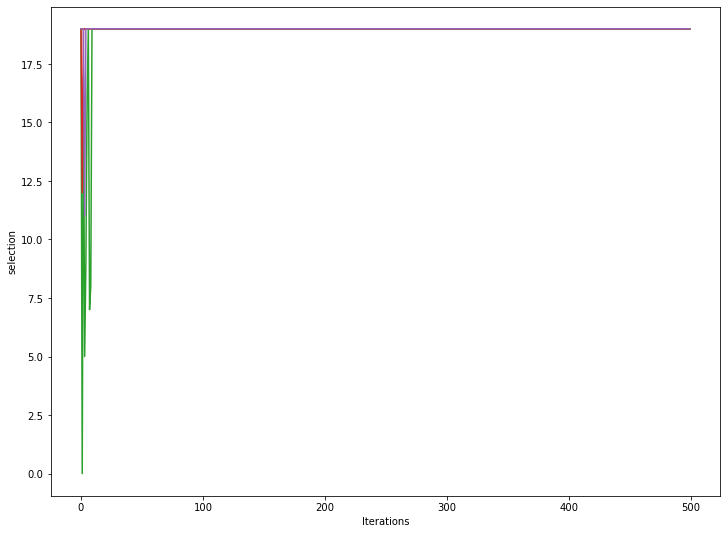

In [15]:
nu.plot_all('../logs', 'oful_select(t)', 'selection', seeds, rows=500)

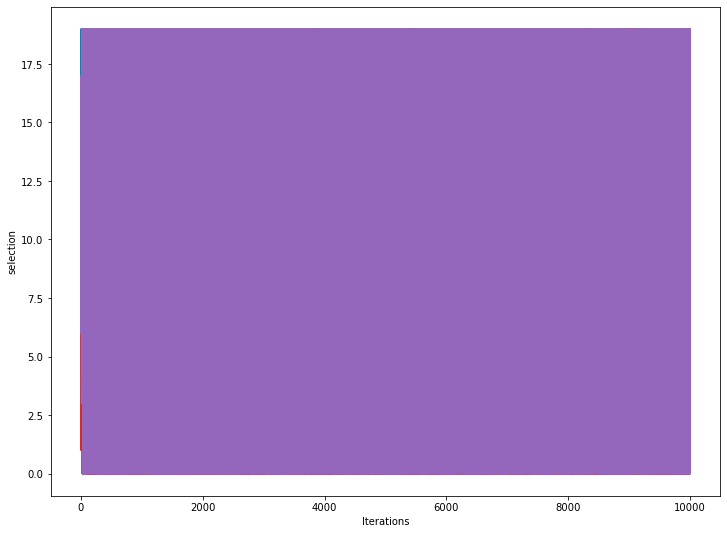

In [16]:
nu.plot_all('../logs', 'oful_meta(t)', 'selection', seeds)

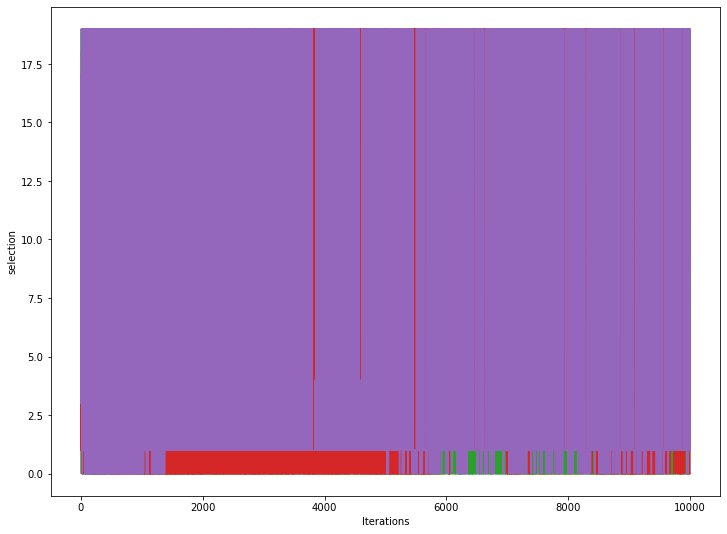

In [17]:
nu.plot_all('../logs', 'oful_maximin(t)', 'selection', seeds)

## CMB, constructive approach (different parameter) (c)

This time I construct a representation of the desired hls rank starting from (the same) reward function

In [18]:
y = r0._rewards()

In [19]:
reps = [make_hls_rank(y, dim=dim, rank=i, transform=True, normalize=True) for i in range(1, dim+1)]

for i, r in enumerate(reps):
    assert np.allclose(r._rewards(), y)  #All representations are equivalent
    assert hls_rank(r) == i+1 #But with different HLS ranks
    assert spans(r) #All representations still span R^d
    print('%d/%d %s %f %f' % (hls_rank(r), rank(r), '(CMB)' if is_cmb(r) else '', r.opt_feat_bound(), r.opt_feat_bound(reduce=np.min)))
    
#Buldi multi-representation problem
problem = FiniteMultiBandit(nc, na, reps)

1/20 (CMB) 6.862986 0.014743
2/20 (CMB) 7.309104 0.014743
3/20 (CMB) 7.604575 0.014743
4/20 (CMB) 7.837374 0.014743
5/20 (CMB) 7.933223 0.014743
6/20 (CMB) 7.933223 0.199353
7/20 (CMB) 7.933223 0.199353
8/20 (CMB) 7.933223 0.199353
9/20 (CMB) 7.933223 0.199353
10/20 (CMB) 7.933223 0.199353
11/20 (CMB) 8.544089 0.199353
12/20 (CMB) 8.544089 0.199353
13/20 (CMB) 8.544089 0.199353
14/20 (CMB) 8.544089 0.199353
15/20 (CMB) 8.544089 0.199353
16/20 (CMB) 8.544089 0.199353
17/20 (CMB) 8.544089 0.199353
18/20 (CMB) 8.544089 0.199353
19/20 (CMB) 8.544089 0.199353
20/20 (CMB) 8.544089 0.199353


Regret of OFUL with different representations

In [20]:
params = []
for i in range(len(reps)):
    problem.select_rep(i)
    name = 'oful_rank%d(c)' % hls_rank(reps[i])
    for seed in seeds:
        params.append(oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname=name))

/Users/papini/lrcb/lrcb/logger.py:69: UserWarning: Could not write data to csv!
  warnings.warn('Could not write data to csv!')


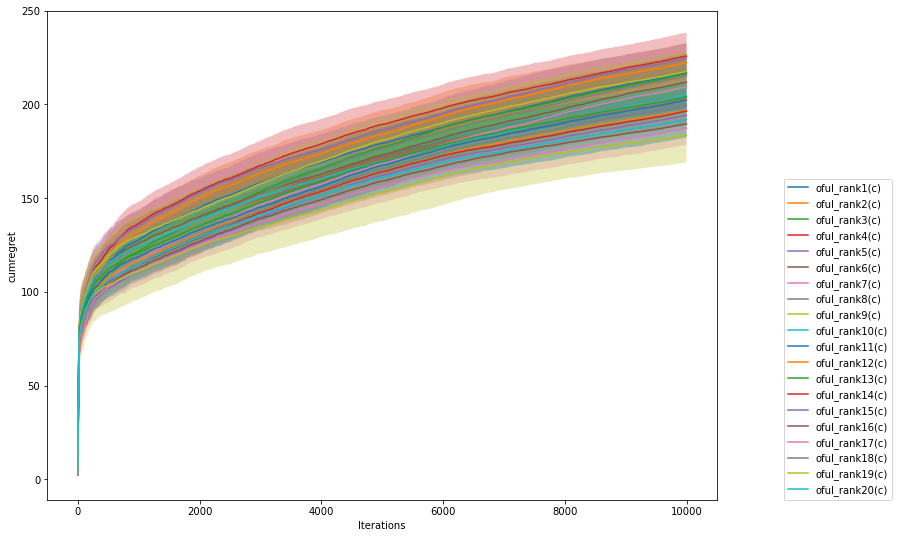

In [21]:
names = ['oful_rank%d(c)' % (i+1) for i in range(dim)] 
nu.compare('../logs', names, 'cumregret', seeds)

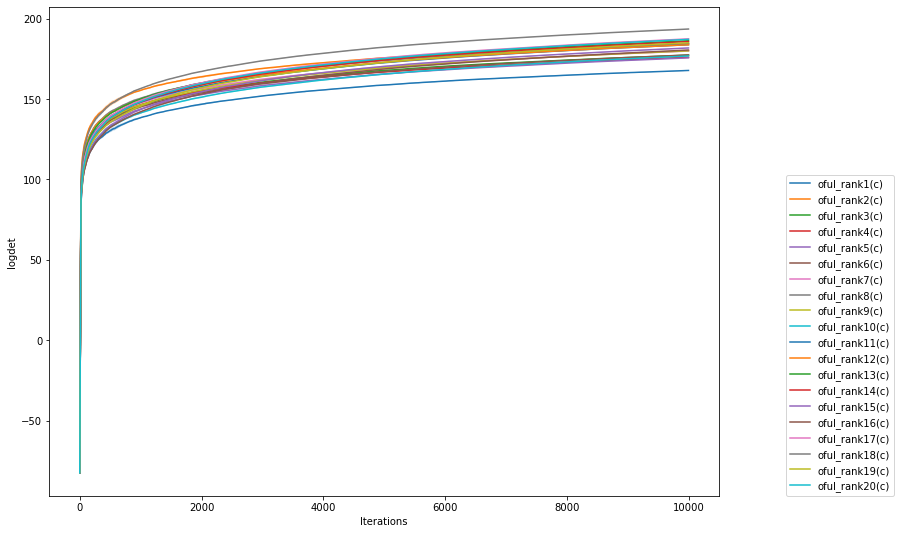

In [22]:
nu.compare('../logs', names, 'logdet', seeds)

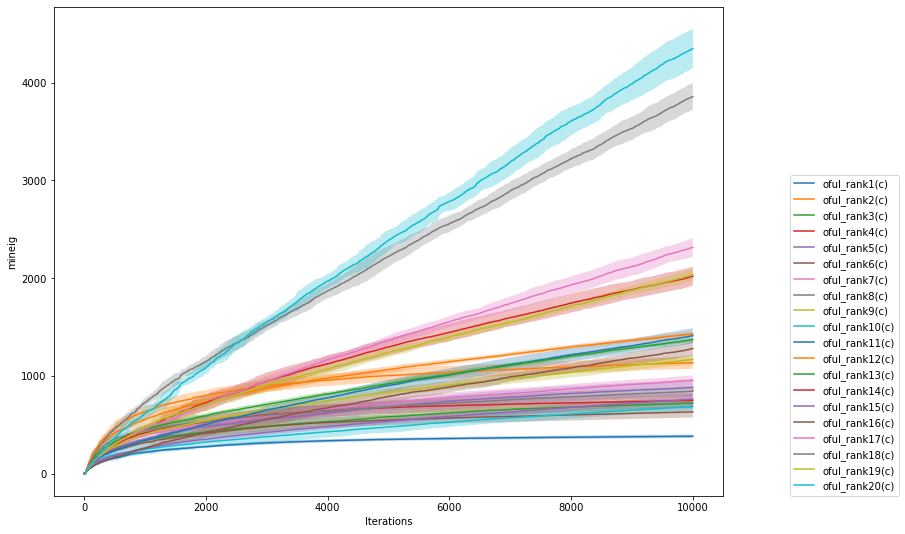

In [23]:
nu.compare('../logs', names, 'mineig', seeds)

(Final) cumulated regret

In [24]:
ranking = nu.tournament('../logs', names, 'cumregret', seeds)
ranking

[('oful_rank19(c)', 183.4671102285999),
 ('oful_rank17(c)', 187.34554406002036),
 ('oful_rank16(c)', 189.61411482787327),
 ('oful_rank20(c)', 191.98516632064147),
 ('oful_rank15(c)', 194.26500217830716),
 ('oful_rank14(c)', 196.43217078342605),
 ('oful_rank12(c)', 196.84491063038632),
 ('oful_rank18(c)', 199.3774018997939),
 ('oful_rank11(c)', 202.36312686788065),
 ('oful_rank13(c)', 204.06377995885677),
 ('oful_rank10(c)', 204.51492858862056),
 ('oful_rank7(c)', 209.49989796939195),
 ('oful_rank6(c)', 211.95997817922103),
 ('oful_rank8(c)', 215.34292345870318),
 ('oful_rank3(c)', 216.3507669689006),
 ('oful_rank1(c)', 217.04822797976612),
 ('oful_rank9(c)', 217.55446244256018),
 ('oful_rank2(c)', 222.31680342216367),
 ('oful_rank5(c)', 224.54847574787885),
 ('oful_rank4(c)', 225.80683866770292)]

Regret of model-selection algorithm compared to best model

In [25]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta/20, param_bound, seed=seed, verbose=False, logname='oful_select(c)')

In [26]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta/20, param_bound, seed=seed, verbose=False, logname='oful_maximin(c)')

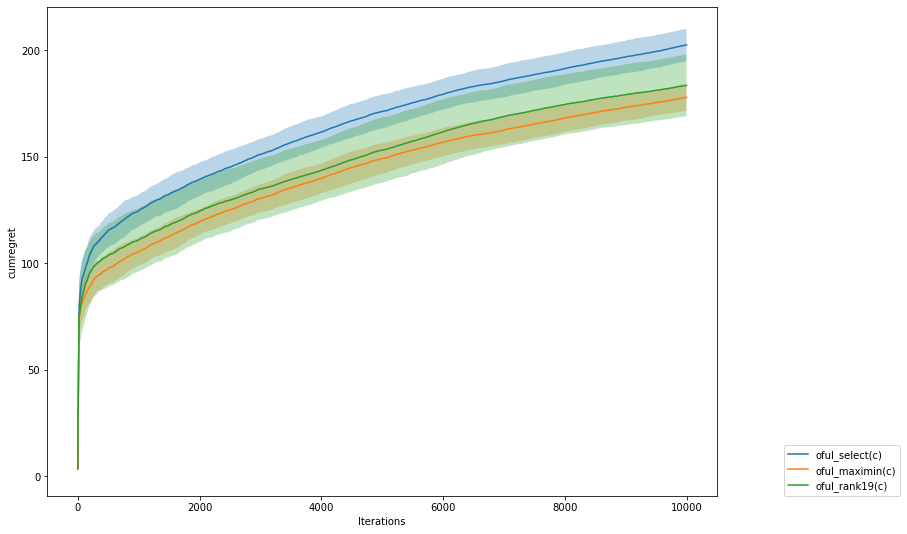

In [27]:
best = ranking[0][0]
nu.compare('../logs', ['oful_select(c)', 'oful_maximin(c)', best], 'cumregret', seeds)

Representations selected by model-selection algorithm

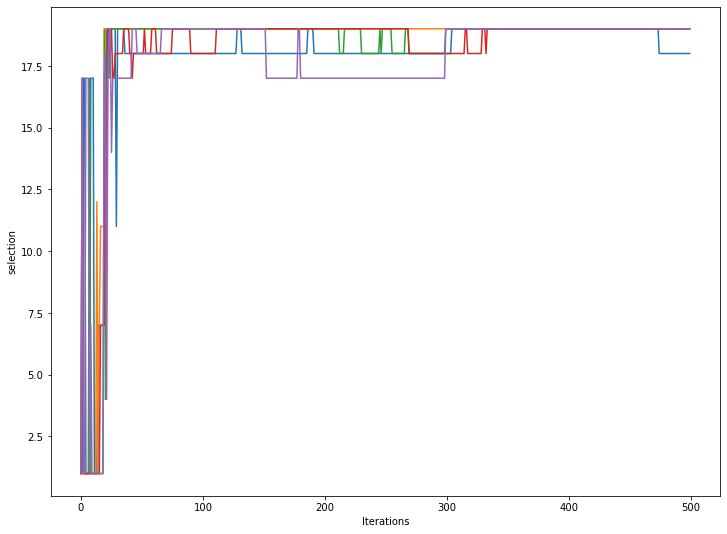

In [28]:
nu.plot_all('../logs', 'oful_select(c)', 'selection', seeds, rows=500)

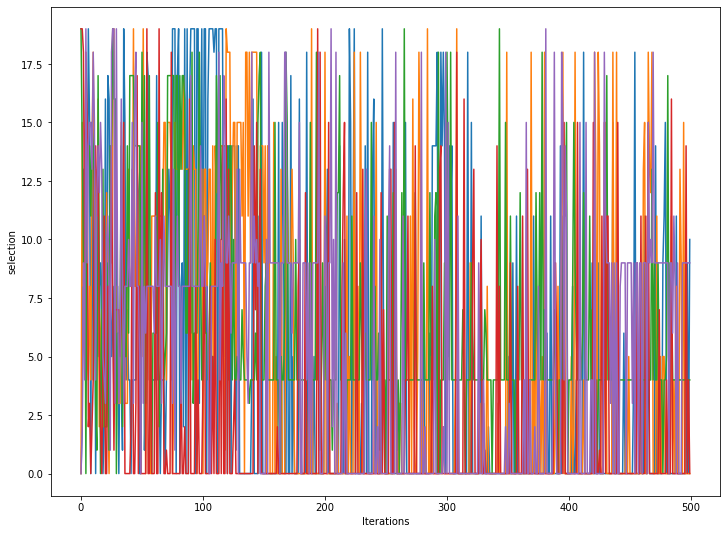

In [29]:
nu.plot_all('../logs', 'oful_maximin(c)', 'selection', seeds, rows=500)

## Why the difference? (different HLS representations)

Original HLS representation

In [30]:
rA = r0

Constructed HLS representation

In [31]:
rB = make_hls_rank(r0._rewards(), dim=dim, rank=dim)

Both are HLS and equivalent

In [32]:
assert rA == rB
assert is_hls(rA)
assert is_hls(rB)

But the performance of OFUL is different

In [33]:
problem = FiniteMultiBandit(nc, na, [rA, rB])

In [34]:
for seed in seeds:
        problem.select_rep(0)
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname='ofulA')
        problem.select_rep(1)
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname='ofulB')

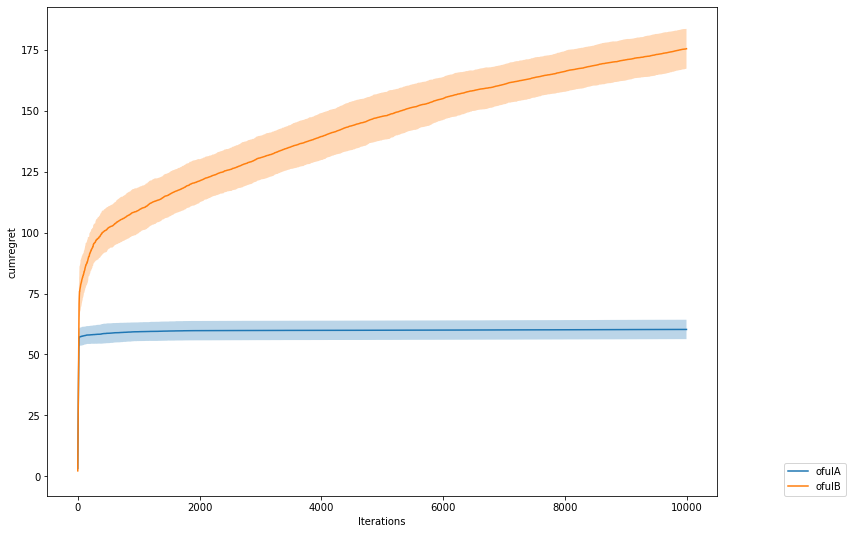

In [35]:
nu.compare('../logs', ['ofulA', 'ofulB'], 'cumregret', seeds)

The reason may be that the minimum eigenvalue of optimal features is different

In [36]:
hls_lambda(rA)

2.2446014092774123

In [37]:
hls_lambda(rB)

0.40487967726451785

In [38]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta/2, param_bound, seed=seed, verbose=False, logname='oful_selectAB')

In [39]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta/2, param_bound, seed=seed, verbose=False, logname='oful_maximinAB')

oful_select is able to select the best representation

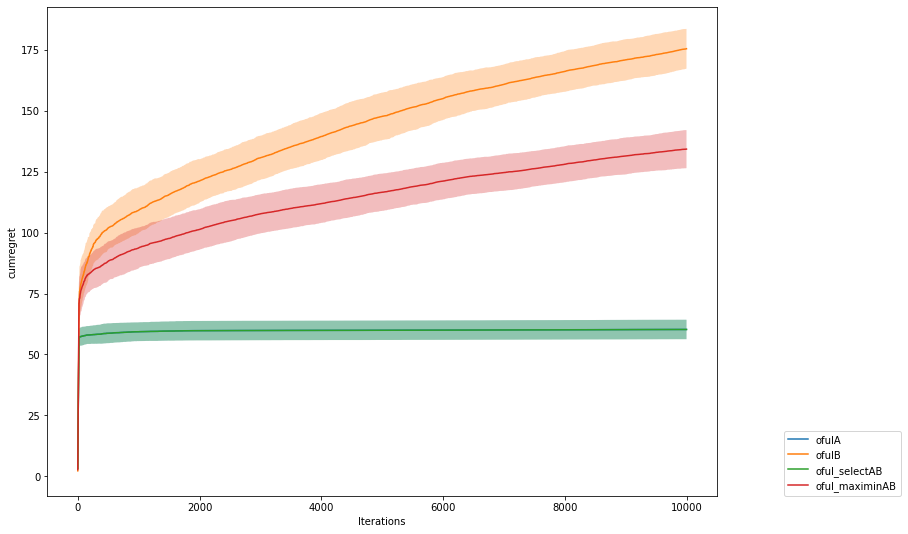

In [40]:
nu.compare('../logs', ['ofulA', 'ofulB', 'oful_selectAB', 'oful_maximinAB'], 'cumregret', seeds)

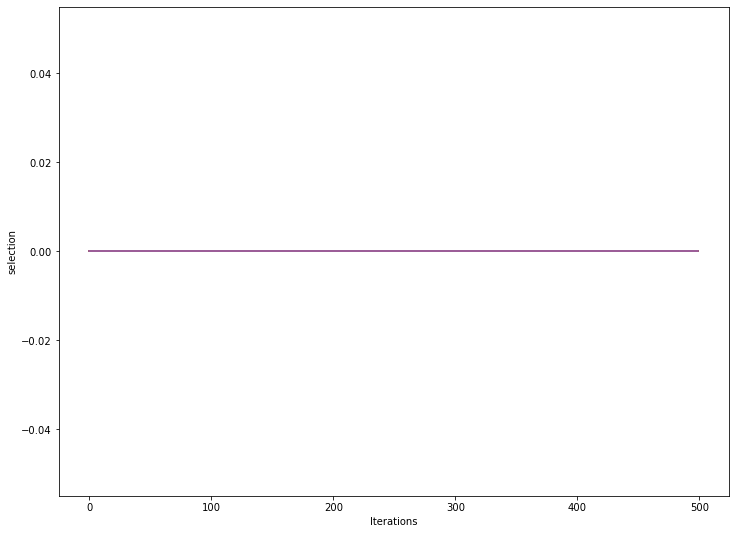

In [41]:
nu.plot_all('../logs', 'oful_selectAB', 'selection', seeds, rows=500)

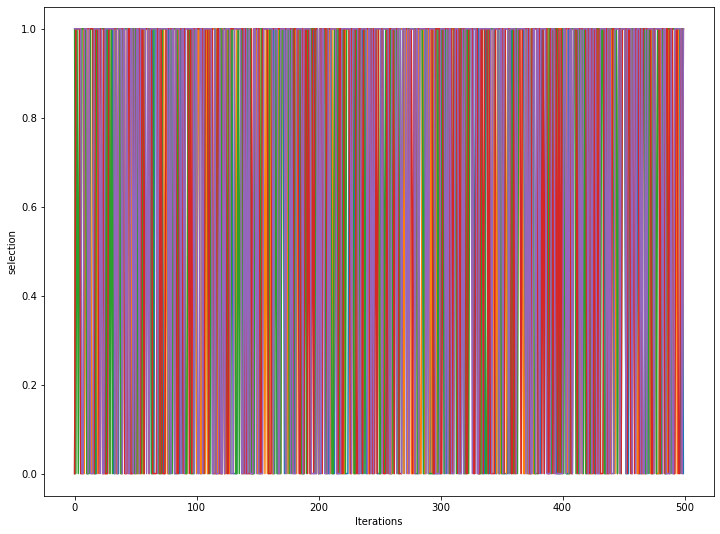

In [42]:
nu.plot_all('../logs', 'oful_maximinAB', 'selection', seeds, rows=500)

## Not CMB (destructive, different param) (n)

I make the original representation NOT CMB while preserving HLS

In [43]:
rr = derank_cmb(r0, save_hls=True)
assert rr == r0
assert is_hls(rr)
assert not is_cmb(rr)

In [44]:
reps = [derank_hls(rr, i, transform=True) for i in range(1, dim)] #Random transformation preserving equivalence
reps.append(rr)

for i, r in enumerate(reps[:-1]):
    assert r == reps[-1] #All representations are equivalent
    assert not np.allclose(r._param, reps[-1]._param) #But with different parameters!
    assert not is_hls(r) #Only the original one is HLS
    assert spans(r) #All representations still span R^d
    assert not is_cmb(r) #None of them is CMB
    print('%d/%d %s %f %f' % (hls_rank(r), rank(r), '(CMB)' if is_cmb(r) else '', r.feat_bound(), r.opt_feat_bound()))
print('%d/%d %s %f %f' % (hls_rank(reps[-1]), rank(reps[-1]), '(CMB)' if is_cmb(r) else '', reps[-1].feat_bound(), reps[-1].opt_feat_bound()))

#Buldi multi-representation problem
problem = FiniteMultiBandit(nc, na, reps)

1/20  17.423838 7.095076
2/20  17.423838 9.770280
3/20  17.423838 12.948599
4/20  17.423838 12.948599
5/20  17.423838 12.948599
6/20  17.423838 12.948599
7/20  17.423838 12.948599
8/20  17.423838 12.948599
9/20  17.423838 12.948599
10/20  17.423838 12.948599
11/20  17.423838 12.948599
12/20  17.423838 12.948599
13/20  17.423838 12.948599
14/20  17.423838 12.948599
15/20  17.423838 12.948599
16/20  17.423838 12.948599
17/20  17.423838 13.384644
18/20  17.423838 13.384644
19/20  17.423838 13.384644
20/20  17.423838 14.017054


Regret of OFUL with different representations

In [45]:
for i in range(len(reps)):
    problem.select_rep(i)
    name = 'oful_rank%d(n)' % hls_rank(reps[i])
    for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname=name)

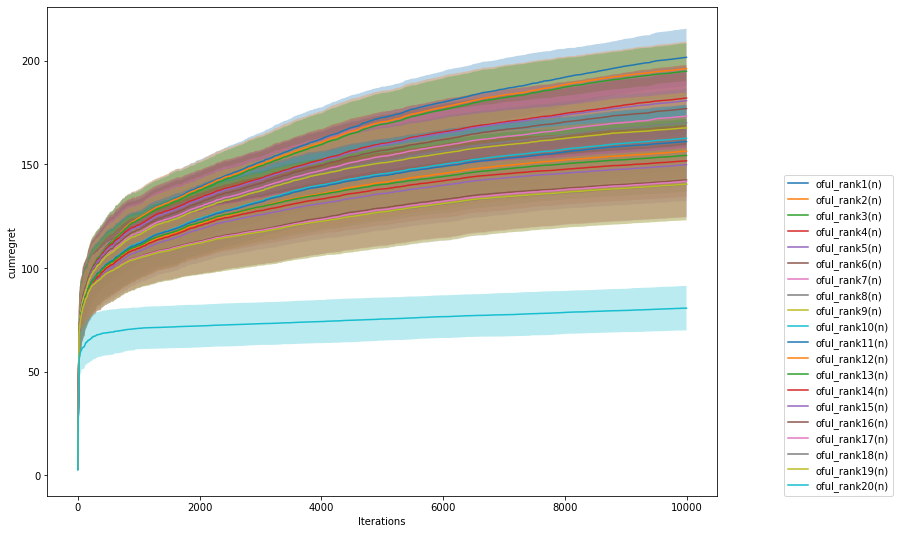

In [46]:
names = ['oful_rank%d(n)' % (i+1) for i in range(dim)]
nu.compare('../logs', names, 'cumregret', seeds)

(Final) cumulated regret is (almost) sorted by hls rank, with the HLS representation having a large advantage

In [47]:
ranking = nu.tournament('../logs', names, 'cumregret', seeds)
ranking

[('oful_rank20(n)', 80.57778742431104),
 ('oful_rank18(n)', 140.32807906384548),
 ('oful_rank19(n)', 140.4155127206936),
 ('oful_rank17(n)', 141.79664415543178),
 ('oful_rank16(n)', 142.4665995879888),
 ('oful_rank15(n)', 149.8138876367685),
 ('oful_rank14(n)', 151.67675581127156),
 ('oful_rank13(n)', 154.2478285944322),
 ('oful_rank12(n)', 156.3230642094789),
 ('oful_rank11(n)', 160.97328719501175),
 ('oful_rank10(n)', 162.53540916841044),
 ('oful_rank9(n)', 167.57568300045207),
 ('oful_rank8(n)', 170.08036903609863),
 ('oful_rank7(n)', 173.22789002656717),
 ('oful_rank6(n)', 176.86586013532974),
 ('oful_rank5(n)', 180.71172298673116),
 ('oful_rank4(n)', 181.980559020554),
 ('oful_rank3(n)', 194.93142983267344),
 ('oful_rank2(n)', 196.20997185734242),
 ('oful_rank1(n)', 201.61307911198074)]

Regret of model-selection algorithm compared to best model

In [48]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta/20, param_bound, seed=seed, verbose=False, logname='oful_select(n)')

In [49]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta/20, param_bound, seed=seed, verbose=False, logname='oful_maximin(n)')

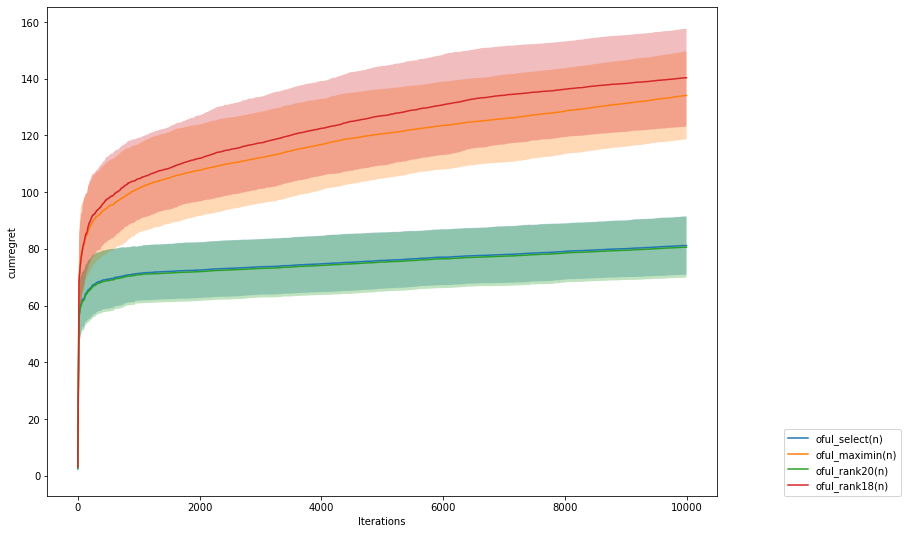

In [50]:
best = ranking[0][0]
nu.compare('../logs', ['oful_select(n)', 'oful_maximin(n)', best, ranking[1][0]], 'cumregret', seeds)

Representations selected by model-selection algorithm

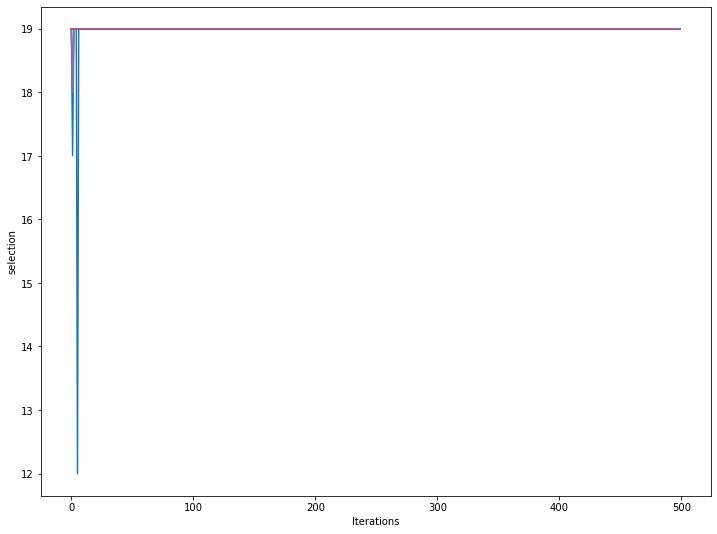

In [51]:
nu.plot_all('../logs', 'oful_select(n)', 'selection', seeds, rows=500)

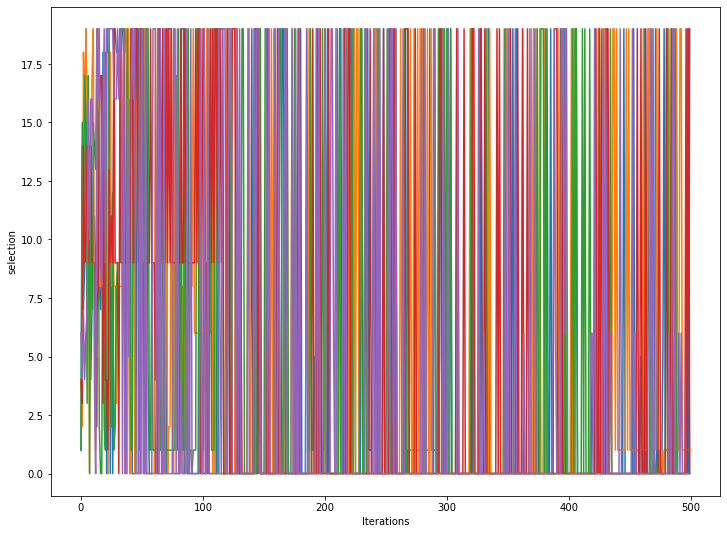

In [52]:
nu.plot_all('../logs', 'oful_maximin(n)', 'selection', seeds, rows=500)